### About 

"""
#++++++++++++++++++++++++++++++++++++++++++++++

    Project: Part of final project for Georgia Tech Institute of Technology course DL, CS 7643. 

    Totality of this code is non-proprietary and may be used at will. 

#++++++++++++++++++++++++++++++++++++++++++++++


Description: 

@brief a notebook defining initial prototyping of model definition, dataset object instantiator, model trainer, and actual model training and evaluation.

@author: Greg Zdor (gzdor@icloud.com)

@date Date_Of_Creation: 3/25/2023 

@date Last_Modification 3/25/2023 

No Copyright - use at will

"""

In [1]:
# Imports 

# System level imports 
import os 
import sys
import time 
import yaml
from datetime import datetime

# ML and data science imports 
import torch
import torchinfo
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

# Add local source files to namespace 
sys.path.append('../../')

# Local imports
from pkgs.utils.plotting_utils import * 
from pkgs.data_loaders.memory_mapper import load_parameters, SigMFDataMMapper
from pkgs.data_loaders.sigmf_dataset import SigMFDataMMapper, SigMFDataset, IQDataAugmenter

now = datetime.now()
print(f'\n\nLast time this cell was run was \n\n  {now.strftime("%d/%m/%Y %H:%M:%S")}\n\n')




Last time this cell was run was 

  26/03/2023 00:17:15




User, update the following path according to your repo  location

In [2]:
repo_root_path = r"/mnt/c/Users/gregt/Desktop/academic_life/ga_tech_cs7643_deep_learning/Radio_Frequency_Fingerprinting_802.11/"

#### Define dataset

In [3]:
# Set up dataset object
dataset_config_path = os.path.join(repo_root_path, "src", "pkgs", "data_loaders", "memory_mapper.yml")
with open(dataset_config_path, "rt") as h_file:
    parameters = yaml.safe_load(h_file)


memmapper = SigMFDataMMapper(parameters)
dataset = SigMFDataset("training", memmapper, transform = IQDataAugmenter())

#### Visualize example model input tensor features from dataset

Single raw data sample is 2d tensor of shape:  torch.Size([2, 128])


Creating time domain plot.




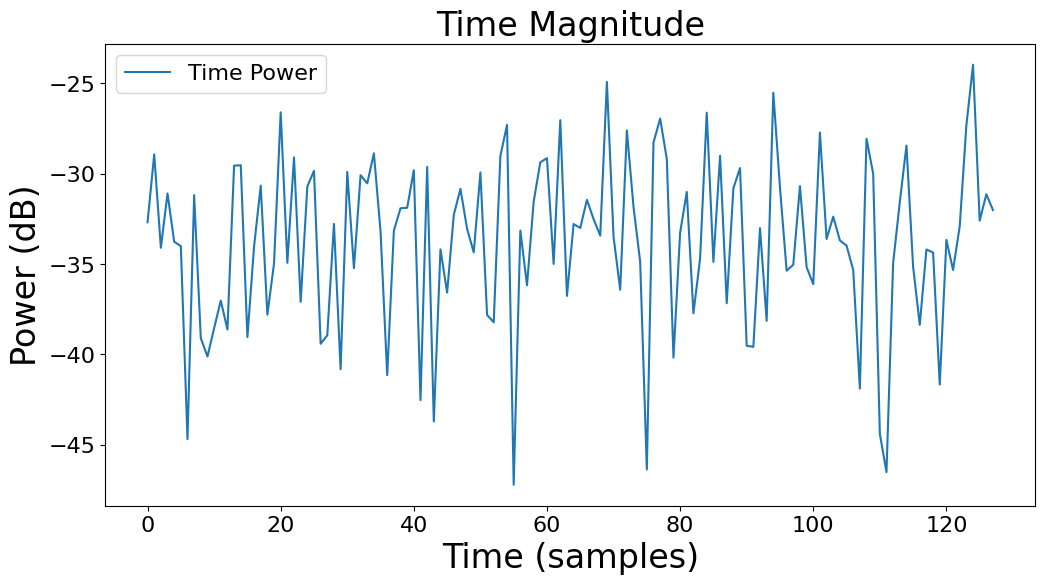



Creating frequency domain plot.




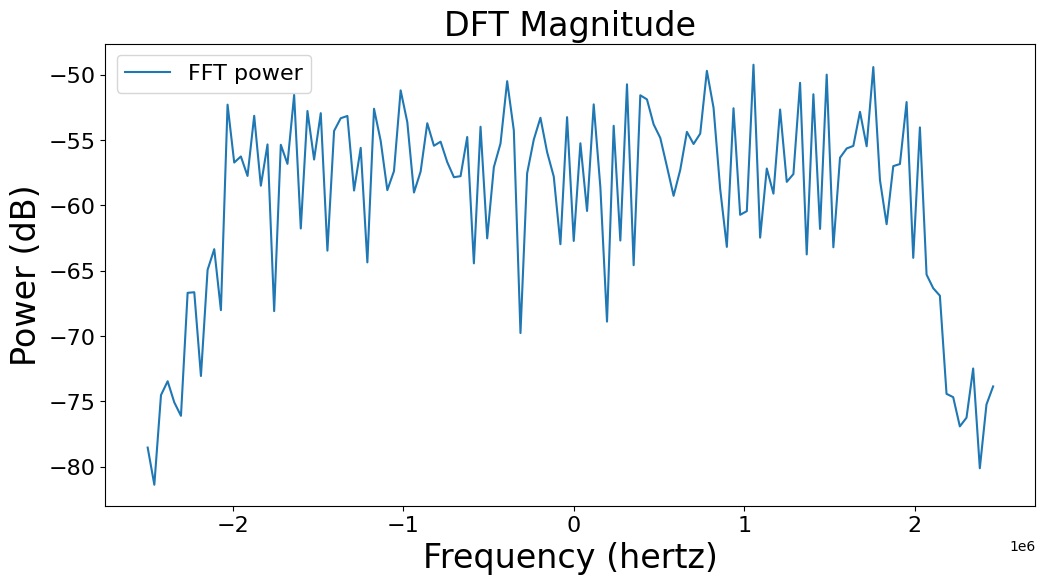

In [77]:
# Visualize samples from dataset 
real_samples  = dataset[0][0][0].numpy() 
imag_samples  = dataset[0][0][1].numpy()
iq = real_samples + imag_samples*1j

print(f'Single raw data sample is 2d tensor of shape:  {dataset[0][0].shape}')

create_time_domain_plot(iq)

create_dft(iq, 128, 5e6)

#### Create PyTorch Lightning data module 

In [11]:
# Create Pytorch Lightning module for dataset 

class LightningOracleDataset(pl.LightningDataModule): 

    def __init__(self): 
        """
        @brief constructor 

        @type parameters dict 
        @param parameters the input parameters from the mem mapper yaml config file.
        """

        super(LightningOracleDataset, self).__init__() 

        self.mmapper = SigMFDataMMapper(parameters)
        self.batch_size = parameters.get("batch_size", 1024)
        self.num_workers = parameters.get("num_workers", 0)


    def setup(self, stage: str):

        self.sigmf_training =\
            SigMFDataset("training",
                         self.mmapper,
                         IQDataAugmenter())
        
        self.sigmf_validation =\
            SigMFDataset("validation", self.mmapper)
        
        self.sigmf_test = SigMFDataset("test", self.mmapper)


    def train_dataloader(self):
        return DataLoader(self.sigmf_training,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=True,
                          pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.sigmf_validation,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.sigmf_test,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          pin_memory=True)


In [80]:
# Extract batch for data loader

dm = LightningOracleDataset()

dm.setup(stage="training")

dl = dm.train_dataloader()

batch = dl.__iter__().__next__()

In [83]:
batch[0].shape

torch.Size([1024, 2, 128])

In [84]:
batch[1].shape

torch.Size([1024, 1])

In [85]:
batch[1][1:25]

tensor([[22],
        [ 0],
        [29],
        [ 1],
        [22],
        [14],
        [ 2],
        [ 4],
        [ 0],
        [20],
        [28],
        [20],
        [19],
        [ 6],
        [27],
        [ 9],
        [12],
        [15],
        [16],
        [12],
        [18],
        [17],
        [29],
        [24]], dtype=torch.int32)

#### Define neural network

In [133]:
cnn_classifier_cfg = {

    "num_classes"                 :        32, 
    "vector_len"                  :        128, # length in time of input signal sequence
    "n_features"                  :        2, # I and Q signal dimensions 
    "max_pool_kernel_size"        :        2, 
    "max_pool_stride"             :        1,
    "n_conv_layers"               :        2,
    "conv_layers"                 :  
        {
            "conv_1_n_filters"    :        128, 
            "conv_1_n_stride"     :        1, 
            "conv_1_kernal_size"  :        3,
            "conv_1_padding"      :        1, 
            "conv_2_n_filters"    :        16, 
            "conv_2_n_stride"     :        1, 
            "conv_2_kernal_size"  :        3,
            "conv_2_padding"      :        1, 
        }, 
    "conv_activations"            :        "Relu",
    "n_dense_layers"              :        2, 
    "dense_layers"                :
        {
            "dense_1_hidden_size" :        128, 
            "dense_2_hidden_size" :        128, 
            "dense_1_dropout"     :        0.2, 
            "dense_2_dropout"     :        0.2, 
        },
    "last_dense_layer_size"       :        64,
}

In [134]:
# Plain PyTorch model 

class CNNClassifier(nn.Module):
    
    def __init__(self, cfg):
        """
        @brief class constructor for convolution-based neural network 
        classifier. 

        @type cfg dict 
        @param cfg a dictionary of network configuration parameter values 
        """

        super(CNNClassifier, self).__init__()

        self.conv_1 = nn.Conv1d(
            cfg['n_features'],
            cfg['conv_layers']['conv_1_n_filters'],
            kernel_size = cfg['conv_layers']['conv_1_kernal_size'],
            stride = cfg['conv_layers']['conv_1_n_stride'], 
            padding = cfg['conv_layers']['conv_1_padding']
            )

        self.conv_2 = nn.Conv1d(
            cfg['conv_layers']['conv_1_n_filters'],
            cfg['conv_layers']['conv_2_n_filters'],
            kernel_size = cfg['conv_layers']['conv_2_kernal_size'],
            stride = cfg['conv_layers']['conv_2_n_stride'], 
            padding = cfg['conv_layers']['conv_2_padding']
            )

        self.conv_activation = nn.ReLU()

        self.maxpool = nn.MaxPool1d(cfg['max_pool_kernel_size'], cfg['max_pool_stride']) 

        dense_layer_input_size = 2016 #TODO parameterize this - remove hardcoded value

        self.dense_1 =  nn.Linear(dense_layer_input_size,
                                cfg['dense_layers']['dense_1_hidden_size'])

        self.dense_2 =  nn.Linear(cfg['dense_layers']['dense_2_hidden_size'],
                                cfg['last_dense_layer_size'])

        self.dense_drop_1 = nn.Dropout(cfg['dense_layers']['dense_1_dropout'])

        self.dense_drop_2 = nn.Dropout(cfg['dense_layers']['dense_2_dropout'])

        self.output_dense_layer = nn.Linear(cfg['last_dense_layer_size'], cfg['num_classes'])

        self.cfg = cfg

    def forward(self, x):
        """"
        @brief executes computation graph forward pass 

        @type x tensor 
        @param x neural network input tensor, of shape [batch_size, 2, 128]
        """

        # Convolution layers
        x = self.conv_1(x)
        x = self.conv_activation(x)
        x = self.maxpool(x)

        if self.cfg['n_conv_layers'] > 1: 
            x = self.conv_2(x)
            x = self.conv_activation(x)
            x = self.maxpool(x)

        x = torch.flatten(x, 1) 

        # Fully connected layers 
        x = self.dense_1(x)
        x = self.dense_drop_1(x)

        if self.cfg['n_dense_layers'] > 1: 
            x = self.dense_2(x)
            x = self.dense_drop_2(x)

        probabilities = self.output_dense_layer(x)

        return probabilities

In [135]:
# View model s
batch_size = 16
cnn_model = CNNClassifier(cnn_classifier_cfg)

input_tensor_size = (batch_size, 2, 128)
model_info = torchinfo.summary(cnn_model, input_size = input_tensor_size)
print(f'\n\nModel summary\n\n{model_info}\n\n')

# Pass in dummy data into model 
x = torch.rand(1024, 2, 128)
cnn_model.forward(x)

/home/gregzdor/miniconda3/envs/rf-fingerprinting-proj-cs7643/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/gregzdor/miniconda3/envs/rf-fingerprinting-proj-cs7643/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()




Model summary

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [16, 32]                  --
├─Conv1d: 1-1                            [16, 128, 128]            896
├─ReLU: 1-2                              [16, 128, 128]            --
├─MaxPool1d: 1-3                         [16, 128, 127]            --
├─Conv1d: 1-4                            [16, 16, 127]             6,160
├─ReLU: 1-5                              [16, 16, 127]             --
├─MaxPool1d: 1-6                         [16, 16, 126]             --
├─Linear: 1-7                            [16, 128]                 258,176
├─Dropout: 1-8                           [16, 128]                 --
├─Linear: 1-9                            [16, 64]                  8,256
├─Dropout: 1-10                          [16, 64]                  --
├─Linear: 1-11                           [16, 32]                  2,080
Total params: 275,568
Trainable params: 275,568
Non-t

tensor([[-0.0278, -0.0556, -0.1535,  ...,  0.2223,  0.0273, -0.0736],
        [ 0.0367, -0.1013, -0.1429,  ...,  0.2394,  0.0707, -0.1311],
        [ 0.0441, -0.0684, -0.0913,  ...,  0.2254, -0.0021, -0.1405],
        ...,
        [ 0.0165, -0.0112, -0.1355,  ...,  0.2085, -0.0285, -0.0968],
        [-0.0319, -0.0454, -0.0930,  ...,  0.2213,  0.0386, -0.0913],
        [ 0.0474, -0.0287, -0.0838,  ...,  0.1601,  0.0044, -0.1132]],
       grad_fn=<AddmmBackward0>)

In [141]:
# Wrap model in Lightning module 

class LightningCNNClassifier(pl.LightningModule): 
    
    def __init__(self, cfg):
        """
        @brief class constructor for convolution-based neural network 
        classifier. 

        @type cfg dict 
        @param cfg a dictionary of network configuration parameter values 
        """

        super(LightningCNNClassifier, self).__init__()

        self.conv_1 = nn.Conv1d(
            cfg['n_features'],
            cfg['conv_layers']['conv_1_n_filters'],
            kernel_size = cfg['conv_layers']['conv_1_kernal_size'],
            stride = cfg['conv_layers']['conv_1_n_stride'], 
            padding = cfg['conv_layers']['conv_1_padding']
            )

        self.conv_2 = nn.Conv1d(
            cfg['conv_layers']['conv_1_n_filters'],
            cfg['conv_layers']['conv_2_n_filters'],
            kernel_size = cfg['conv_layers']['conv_2_kernal_size'],
            stride = cfg['conv_layers']['conv_2_n_stride'], 
            padding = cfg['conv_layers']['conv_2_padding']
            )

        self.conv_activation = nn.ReLU()

        self.maxpool = nn.MaxPool1d(cfg['max_pool_kernel_size'], cfg['max_pool_stride']) 

        dense_layer_input_size = 2016 #TODO parameterize this - remove hardcoded value

        self.dense_1 =  nn.Linear(dense_layer_input_size,
                                cfg['dense_layers']['dense_1_hidden_size'])

        self.dense_2 =  nn.Linear(cfg['dense_layers']['dense_2_hidden_size'],
                                cfg['last_dense_layer_size'])

        self.dense_drop_1 = nn.Dropout(cfg['dense_layers']['dense_1_dropout'])

        self.dense_drop_2 = nn.Dropout(cfg['dense_layers']['dense_2_dropout'])

        self.output_dense_layer = nn.Linear(cfg['last_dense_layer_size'], cfg['num_classes'])

        self.cfg = cfg


    def forward(self, x):
        """"
        @brief executes computation graph forward pass 

        @type x tensor 
        @param x neural network input tensor, of shape [batch_size, 2, 128]
        """

        # Convolution layers
        x = self.conv_1(x)
        x = self.conv_activation(x)
        x = self.maxpool(x)

        if self.cfg['n_conv_layers'] > 1: 
            x = self.conv_2(x)
            x = self.conv_activation(x)
            x = self.maxpool(x)

        x = torch.flatten(x, 1) 

        # Fully connected layers 
        x = self.dense_1(x)
        x = self.dense_drop_1(x)

        if self.cfg['n_dense_layers'] > 1: 
            x = self.dense_2(x)
            x = self.dense_drop_2(x)

        probabilities = self.output_dense_layer(x)

        return probabilities


    def configure_optimizers(self): 
        optimizer = torch.optim.Adam(self.parameters(), lr  = 1e-3)
        return optimizer 
    

    def cross_entropy_loss(self, logits, labels): 
        loss = torch.nn.functional.nll_loss(logits, labels, reduction = 'mean')
        return loss


    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)        
        y = torch.flatten(y) #NOTE - added since SigMFDataLoader labels are dtype=torch.int32
        y = y.type(torch.LongTensor)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        return loss


    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        y = torch.flatten(y) #NOTE - added since SigMFDataLoader labels are dtype=torch.int32
        y = y.type(torch.LongTensor)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)


#### Execute training

Run example forward pass to make sure all tensor dimensionalites are aligned

In [142]:
data_module = LightningOracleDataset()

model = LightningCNNClassifier(cnn_classifier_cfg)

x = batch

print(type(x))

print(x[0].shape)
print(x[1].shape)

print(x[0].dtype)
print(x[1].dtype)

loss = model.training_step(x, 0)

loss

<class 'list'>
torch.Size([1024, 2, 128])
torch.Size([1024, 1])
torch.float32
torch.int32


/home/gregzdor/miniconda3/envs/rf-fingerprinting-proj-cs7643/lib/python3.10/site-packages/pytorch_lightning/core/module.py:411: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(0.0065, grad_fn=<NllLossBackward0>)

Run actual training

In [143]:
# Train model

data_module = LightningOracleDataset()

model = LightningCNNClassifier(cnn_classifier_cfg)

lightning_callbacks = [ 
    pl.callbacks.ModelCheckpoint(monitor = "val_loss", mode = "min"), 
    pl.callbacks.EarlyStopping(monitor='val_loss', patience=5),
]

# Configure trainer
trainer = pl.Trainer(
    enable_progress_bar = True, 
    enable_checkpointing = True, 
    enable_model_summary = True,
    callbacks = lightning_callbacks, 
    max_epochs = 100, 
    precision = 32, # options are 16 or 32 
) 

    # multi gpu training via gpus=8, distributed_backend='dp' 

# Let Lightning find the optimal learning rate - can be done via one liner: trainer.tune(model)

# # Run learning rate finder
# lr_finder = trainer.tuner.lr_find(model)

# # Results can be found in
# lr_finder.results

# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # Pick point based on plot, or get suggestion
# new_lr = lr_finder.suggestion()

# # update hparams of the model
# model.hparams.lr = new_lr

# Train
trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params
-------------------------------------------------
0 | conv_1             | Conv1d    | 896   
1 | conv_2             | Conv1d    | 6.2 K 
2 | conv_activation    | ReLU      | 0     
3 | maxpool            | MaxPool1d | 0     
4 | dense_1            | Linear    | 258 K 
5 | dense_2            | Linear    | 8.3 K 
6 | dense_drop_1       | Dropout   | 0     
7 | dense_drop_2       | Dropout   | 0     
8 | output_dense_layer | Linear    | 2.1 K 
-------------------------------------------------
275 K     Trainable params
0         Non-trainable params
275 K     Total params
1.102     Total estimated model params size (MB)


/home/gregzdor/miniconda3/envs/rf-fingerprinting-proj-cs7643/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   1%|          | 24/3126 [04:05<8:48:45, 10.23s/it, v_num=19]

#### Evaluate model

In [ ]:
# Calculate average accuracy, confusion matrix

#### Next steps 

implement tuner wrapper - https://towardsdatascience.com/how-to-tune-pytorch-lightning-hyperparameters-80089a281646 